In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
save_model_path = 'models/savedkeypoints.h5'
tflite_model_path = 'models/savedkeypointclassifies.tflite'

In [3]:
num_classes = 4

Data Preprocessing

In [38]:
dataframe = pd.read_csv("keypoints.csv", header=None)
x = dataframe.iloc[:,1:43].values
y = dataframe.iloc[:,0].values

In [39]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
x_scaled =sc.fit_transform(x)

In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=0)

Building NN

In [41]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [42]:
classifier = Sequential()

In [43]:
classifier.add(Dense(42,activation='relu',input_shape =(42,)))
classifier.add(Dropout(0.4))
classifier.add(Dense(50, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(30, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(num_classes,activation='softmax'))


In [44]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 42)                1806      
                                                                 
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2150      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                1530      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                

In [45]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [46]:
cp_callback = ModelCheckpoint(save_model_path,verbose=1,save_weights_only=False)
es_callback =EarlyStopping(patience=20, verbose = 1)

In [47]:
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [48]:
classifier.fit(x_train,y_train,epochs=50, batch_size=32,callbacks=[cp_callback,es_callback],validation_data=(x_test,y_test))

Epoch 1/50
 1/20 [>.............................] - ETA: 21s - loss: 1.3719 - accuracy: 0.3125
Epoch 1: saving model to models\savedkeypoints.h5
20/20 [==============================] - 2s 65ms/step - loss: 1.3313 - accuracy: 0.3415 - val_loss: 1.2573 - val_accuracy: 0.3442
Epoch 2/50
16/20 [=======================>......] - ETA: 0s - loss: 1.2562 - accuracy: 0.4082
Epoch 2: saving model to models\savedkeypoints.h5
20/20 [==============================] - 0s 16ms/step - loss: 1.2612 - accuracy: 0.4069 - val_loss: 1.1643 - val_accuracy: 0.4091
Epoch 3/50
16/20 [=======================>......] - ETA: 0s - loss: 1.1936 - accuracy: 0.4746
Epoch 3: saving model to models\savedkeypoints.h5
20/20 [==============================] - 1s 60ms/step - loss: 1.1854 - accuracy: 0.4853 - val_loss: 1.0621 - val_accuracy: 0.6753
Epoch 4/50
16/20 [=======================>......] - ETA: 0s - loss: 1.1464 - accuracy: 0.5020
Epoch 4: saving model to models\savedkeypoints.h5
20/20 [==========================

In [49]:
classifier.evaluate(x_test,y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 0.9870


[0.1247192844748497, 0.9870129823684692]

In [52]:
from keras.models import load_model

model = load_model(save_model_path)

In [50]:
#making predictions
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis =-1)

In [53]:
model.save(save_model_path)

In [23]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools

Confusion matrix, without normalization
[[16  0  0  2]
 [ 0 58  0  0]
 [ 0  0 51  0]
 [ 0  0  0 27]]


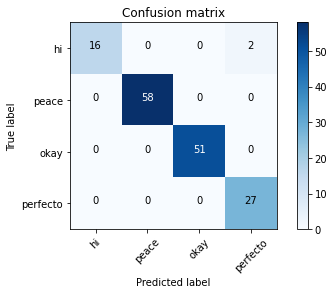

In [51]:
cm = confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_name = ['hi','peace', 'okay','perfecto']
plot_confusion_matrix(cm,classes = class_name)

In [26]:
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        46
           3       0.94      0.97      0.95        30

    accuracy                           0.98       147
   macro avg       0.96      0.95      0.96       147
weighted avg       0.98      0.98      0.98       147



Converting model to tflite

In [27]:
import tensorflow as tf

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open(tflite_model_path, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Raymond\AppData\Local\Temp\tmpck5u97po\assets


INFO:tensorflow:Assets written to: C:\Users\Raymond\AppData\Local\Temp\tmpck5u97po\assets


8864

Inference Test

In [56]:
interpreter = tf.lite.Interpreter(model_path = tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'],np.array([x_test[0]], dtype = np.float32))


In [57]:
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]['index'])
print(result)

[[2.0561370e-03 9.9576807e-01 2.1232706e-03 5.2620006e-05]]
